In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [33]:
data = pd.read_csv(r'Datasets/sales.csv')

In [34]:
data.head()

,Trans_id,Item,Quantity,Price_per_unit,Total_spent,Payment_method,Location,Trans_date
0,TXN_1961373,Coffee,3.04,2.0,6.08,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,3.04,3.0,9.12,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,2.98,1.0,2.98,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,3.02,5.0,15.10,Unknown,Unknown,2023-04-27
4,TXN_3160411,Coffee,3.04,2.0,6.08,Digital Wallet,In-store,2023-06-11


In [35]:
data[(data.Total_spent == 'UNKNOWN') | (data.Total_spent == 'ERROR')]

,Trans_id,Item,Quantity,Price_per_unit,Total_spent,Payment_method,Location,Trans_date


In [36]:
data.replace(['UNKNOWN', 'Missing', 'ERROR'], np.nan, inplace=True)

In [37]:
data['Quantity'] = pd.to_numeric(data['Quantity'],errors='coerce')
data['Price_per_unit'] = pd.to_numeric(data['Price_per_unit'],errors='coerce')
data['Total_spent'] = pd.to_numeric(data['Total_spent'],errors='coerce')

In [38]:
for i in range(len(data)):
    spent = data.loc[i,'Total_spent']
    price = data.loc[i,'Price_per_unit']
    Quant = data.loc[i,'Quantity']
    if pd.isna(spent):
        if pd.notna(price) and pd.notna(Quant):
            data.loc[i,'Total_spent'] = price*Quant

In [39]:
data[(data.Total_spent == 'UNKNOWN') | (data.Total_spent == 'ERROR')]

,Trans_id,Item,Quantity,Price_per_unit,Total_spent,Payment_method,Location,Trans_date


In [40]:
data[(data.Item == 'UNKNOWN') | (data.Item == 'ERROR')]

,Trans_id,Item,Quantity,Price_per_unit,Total_spent,Payment_method,Location,Trans_date


In [41]:
print(len(data[data['Price_per_unit'].isnull()]))
print(len(data[data['Quantity'].isnull()]))
print(len(data[data['Total_spent'].isnull()]))

0
0
0


In [42]:
data['Payment_method'].fillna('Unknown',inplace=True)
data['Location'].fillna('Unknown',inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_18948\3928713434.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Payment_method'].fillna('Unknown',inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_18948\3928713434.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [43]:
data.isnull().mean()*100

Trans_id          0.0
Item              0.0
Quantity          0.0
Price_per_unit    0.0
Total_spent       0.0
Payment_method    0.0
Location          0.0
Trans_date        0.0
dtype: float64

In [44]:
# mean price of each item :
price_mean = data.dropna().groupby('Item')['Price_per_unit'].mean().round(2)
quantity_mean = data.dropna().groupby('Item')['Quantity'].mean().round(2)

data_item_mean = pd.DataFrame({
    'Item': price_mean.index,
    'Price_per_unit': price_mean.values,
    'Quantity': quantity_mean.values
})
data_item_mean

,Item,Price_per_unit,Quantity
0,Cake,3.00,3.06
1,Coffee,2.00,3.04
2,Cookie,1.14,2.80
3,Juice,3.02,2.95
4,Salad,5.00,3.01
5,Sandwich,4.00,3.05
6,Smoothie,3.97,3.19
7,Tea,1.38,4.21


In [45]:
item_to_mean_price = data_item_mean.set_index('Item')['Price_per_unit'].to_dict()
item_to_mean_quantity = data_item_mean.set_index('Item')['Quantity'].to_dict()

In [46]:
item_to_mean_price

{'Cake': 3.0,
 'Coffee': 2.0,
 'Cookie': 1.14,
 'Juice': 3.02,
 'Salad': 5.0,
 'Sandwich': 4.0,
 'Smoothie': 3.97,
 'Tea': 1.38}

In [47]:
data['Price_per_unit'] = data.apply(
    lambda row: item_to_mean_price[row['Item']] if pd.isna(row['Price_per_unit']) and row['Item'] in item_to_mean_price else row['Price_per_unit'],
    axis=1
)

In [48]:
data.isnull().mean()*100

Trans_id          0.0
Item              0.0
Quantity          0.0
Price_per_unit    0.0
Total_spent       0.0
Payment_method    0.0
Location          0.0
Trans_date        0.0
dtype: float64

In [49]:
data['Quantity'] = data.apply(
    lambda row: (row['Total_spent'] / row['Price_per_unit'])
    if (row['Price_per_unit'] != 0 and pd.notna(row['Price_per_unit']) and pd.notna(row['Total_spent']))
    else row['Quantity'],
    axis=1
)

data['Quantity'] = data.apply(
    lambda row : item_to_mean_quantity[row['Item']] if pd.notna(row['Item']) and row['Item'] in item_to_mean_quantity 
    else row['Quantity'],
    axis=1
)

data['Total_spent'] = data.apply(
    lambda row: row['Quantity'] * row['Price_per_unit']
    if (pd.notna(row['Price_per_unit']) and pd.notna(row['Quantity']))
    else row['Total_spent'],
    axis=1
)

In [50]:
data.isnull().mean()*100

Trans_id          0.0
Item              0.0
Quantity          0.0
Price_per_unit    0.0
Total_spent       0.0
Payment_method    0.0
Location          0.0
Trans_date        0.0
dtype: float64

In [51]:
data = data[~(data['Quantity'].isna() | data['Price_per_unit'].isna() | data['Total_spent'].isna())]

In [52]:
data.isnull().mean()*100

Trans_id          0.0
Item              0.0
Quantity          0.0
Price_per_unit    0.0
Total_spent       0.0
Payment_method    0.0
Location          0.0
Trans_date        0.0
dtype: float64

In [53]:
known_items = data[data['Item'].notna()]
unknown_items = data[data['Item'].isna()]

X = known_items[['Price_per_unit', 'Quantity', 'Total_spent']]
y = known_items['Item']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Validation Accuracy: {accuracy:.2%}")


X_unknown = unknown_items[['Price_per_unit', 'Quantity', 'Total_spent']]
predicted_items = model.predict(X_unknown)

Validation Accuracy: 100.00%


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by RandomForestClassifier.

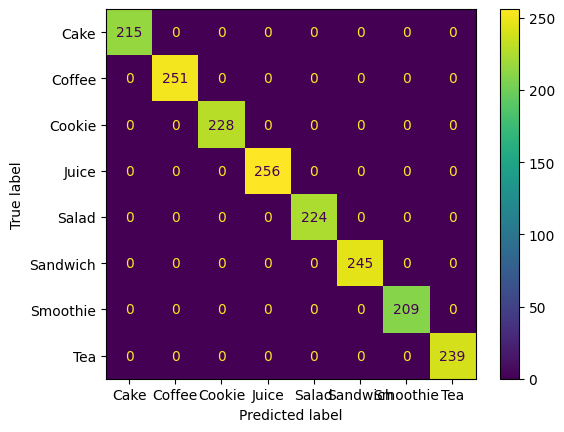

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [ ]:
print(y.value_counts())

Item
Juice       1256
Sandwich    1214
Coffee      1205
Salad       1186
Cake        1138
Cookie      1131
Tea         1109
Smoothie    1094
Name: count, dtype: int64


In [ ]:
data.loc[data['Item'].isna(), 'Item'] = predicted_items

In [ ]:
data.isnull().mean()*100

Trans_id          0.000000
Item              0.000000
Quantity          0.000000
Price_per_unit    0.000000
Total_spent       0.000000
Payment_method    0.000000
Location          0.000000
Trans_date        4.616157
dtype: float64

In [ ]:
missing_idx = data[data['Trans_date'].isna()].index
valid_dates = data['Trans_date'].dropna()
sampled_dates = valid_dates.sample(n=len(missing_idx), replace=True, random_state=42).values
data.loc[missing_idx, 'Trans_date'] = sampled_dates

In [ ]:
data.isnull().mean()*100

Trans_id          0.0
Item              0.0
Quantity          0.0
Price_per_unit    0.0
Total_spent       0.0
Payment_method    0.0
Location          0.0
Trans_date        0.0
dtype: float64

In [ ]:
data.head()

,Trans_id,Item,Quantity,Price_per_unit,Total_spent,Payment_method,Location,Trans_date
0,TXN_1961373,Coffee,3.04,2.0,6.08,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,3.04,3.0,9.12,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,2.98,1.0,2.98,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,3.02,5.0,15.10,Unknown,Unknown,2023-04-27
4,TXN_3160411,Coffee,3.04,2.0,6.08,Digital Wallet,In-store,2023-06-11


In [ ]:
data.to_csv('Datasets/sales.csv',index=False)